# loading data

In [5]:
import os
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
import torch

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Dataset paths
data_paths = {
    "bible": {
        "src": "/kaggle/input/eng-ur-dataset/bible/train.en",
        "tgt": "/kaggle/input/eng-ur-dataset/bible/train.ur"
    },
    "quran": {
        "src": "/kaggle/input/eng-ur-dataset/quran/train.en",
        "tgt": "/kaggle/input/eng-ur-dataset/quran/train.ur"
    }
}

# Function to load text from file
def load_text(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        return [line.strip() for line in f]

# Load raw text data (not tokenized) from both Bible and Quran
src_text_data = []
tgt_text_data = []

for source, paths in data_paths.items():
    src_text_data.extend(load_text(paths["src"]))
    tgt_text_data.extend(load_text(paths["tgt"]))

# Dataset class for translation pairs
class TranslationDataset(Dataset):
    def __init__(self, src_data, tgt_data, tokenizer, max_length=128):
        self.src_data = src_data
        self.tgt_data = tgt_data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.src_data)

    def __getitem__(self, idx):
        # Get raw text data
        src = self.src_data[idx]
        tgt = self.tgt_data[idx]
        
        # Tokenize the text (raw strings) using BERT tokenizer
        src_encoding = self.tokenizer(src, padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt')
        tgt_encoding = self.tokenizer(tgt, padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt')
        
        # Return as tensor (removing the batch dimension from tensors returned by tokenizer)
        return torch.squeeze(src_encoding.input_ids), torch.squeeze(tgt_encoding.input_ids)

# DataLoader for training data
batch_size = 64
train_dataset = TranslationDataset(src_text_data, tgt_text_data, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Print completion message
print("Data loading and preprocessing completed successfully.")
print(f"Number of batches in the dataloader: {len(train_loader)}")

# Sample batch shapes for inspection
i=0
for src_batch, tgt_batch in train_loader:
    print(f"Source batch shape: {src_batch.shape}")
    print(f"Target batch shape: {tgt_batch.shape}")
    if i==2:
        break
    i+=1


Data loading and preprocessing completed successfully.
Number of batches in the dataloader: 210
Source batch shape: torch.Size([64, 128])
Target batch shape: torch.Size([64, 128])
Source batch shape: torch.Size([64, 128])
Target batch shape: torch.Size([64, 128])
Source batch shape: torch.Size([64, 128])
Target batch shape: torch.Size([64, 128])


# transformers

In [ ]:
jj

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout=0.1):
        super(TransformerModel, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 512, d_model))  # Max length 512 for input sequence
        
        self.encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_encoder_layers)
        
        self.decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout)
        self.decoder = nn.TransformerDecoder(self.decoder_layer, num_decoder_layers)
        
        self.fc_out = nn.Linear(d_model, vocab_size)
    
    def forward(self, src, tgt):
        # Embedding and positional encoding
        src = self.embedding(src) + self.positional_encoding[:, :src.size(1), :]
        tgt = self.embedding(tgt) + self.positional_encoding[:, :tgt.size(1), :]
        
        # Ensure the shape is (seq_len, batch_size, d_model) for encoder and decoder
        src = src.permute(1, 0, 2)  # (batch_size, seq_len, d_model) -> (seq_len, batch_size, d_model)
        tgt = tgt.permute(1, 0, 2)  # (batch_size, seq_len, d_model) -> (seq_len, batch_size, d_model)
        
        # Encoding
        memory = self.encoder(src)
        
        # Decoding
        output = self.decoder(tgt, memory)
        
        # Output layer
        logits = self.fc_out(output)
        return logits

# Initialize the model
vocab_size = tokenizer.vocab_size
d_model = 256  # Dimension of the model
nhead = 8  # Number of heads in multiheadattention
num_encoder_layers = 6  # Number of layers in encoder
num_decoder_layers = 6  # Number of layers in decoder
dim_feedforward = 512  # Feedforward layer dimension

model = TransformerModel(vocab_size, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward)

# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training Loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    
    for i, (src_batch, tgt_batch) in enumerate(train_loader):
        src_batch = src_batch.to(device)
        tgt_batch = tgt_batch.to(device)
        
        # Shift target for teacher forcing
        tgt_input = tgt_batch[:, :-1]
        tgt_output = tgt_batch[:, 1:]
        
        optimizer.zero_grad()
        
        # Forward pass
        output = model(src_batch, tgt_input)
        
        # Calculate loss
        output_dim = output.shape[-1]  # Get the vocabulary dimension (last dimension)
        output = output.view(-1, output_dim)
        tgt_output = tgt_output.contiguous().view(-1)
        
        loss = criterion(output, tgt_output)
        total_loss += loss.item()
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader)}")

# Save the trained model
torch.save(model.state_dict(), 'transformer_model.pth')


/usr/local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/5, Loss: 5.409846530641828
Epoch 2/5, Loss: 3.6867617516290574
Epoch 3/5, Loss: 3.6506669214793614
Epoch 4/5, Loss: 3.6416395777747743
Epoch 5/5, Loss: 3.6379820766903106


In [ ]:
# Check if the source and target have consistent shapes
print(src_batch.shape)  # Expected: (batch_size, seq_len)
print(tgt_input.shape)  # Expected: (batch_size, seq_len)


In [17]:
# !pip install sacrebleu rouge-score
import sacrebleu
from rouge_score import rouge_scorer

def compute_bleu_score(predicted, target):
    # Convert tensor to list of strings (for BLEU calculation)
    predicted_text = tokenizer.decode(predicted[0], skip_special_tokens=True)
    target_text = tokenizer.decode(target[0], skip_special_tokens=True)
    
    # Use sacrebleu to compute BLEU score
    bleu = sacrebleu.corpus_bleu([predicted_text], [[target_text]])
    return bleu.score


def compute_rouge_score(predicted, target):
    # Convert tensor to list of strings (for ROUGE calculation)
    predicted_text = tokenizer.decode(predicted[0], skip_special_tokens=True)
    target_text = tokenizer.decode(target[0], skip_special_tokens=True)
    
    # Initialize the scorer and score the predicted and target text
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(target_text, predicted_text)
    
    # Return the ROUGE-1, ROUGE-2, and ROUGE-L F1 scores
    return scores['rouge1'].fmeasure, scores['rouge2'].fmeasure, scores['rougeL'].fmeasure


In [18]:
def evaluate(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    total_bleu_score = 0.0
    total_rouge1 = 0.0
    total_rouge2 = 0.0
    total_rougeL = 0.0
    
    with torch.no_grad():
        for src_batch, tgt_batch in test_loader:
            src_batch = src_batch.to(device)
            tgt_batch = tgt_batch.to(device)
            
            # Shift target for teacher forcing
            tgt_input = tgt_batch[:, :-1]  # Input for the decoder (exclude last token)
            tgt_output = tgt_batch[:, 1:]  # Target output (exclude first token)
            
            # Get model output
            output = model(src_batch, tgt_input)
            
            # Decode the output (usually with argmax or beam search)
            predicted = output.argmax(dim=-1)  # Predicted output sequence
            
            # Compute BLEU and ROUGE scores
            bleu_score = compute_bleu_score(predicted, tgt_output)
            rouge1, rouge2, rougeL = compute_rouge_score(predicted, tgt_output)
            
            total_bleu_score += bleu_score
            total_rouge1 += rouge1
            total_rouge2 += rouge2
            total_rougeL += rougeL
            
    avg_bleu_score = total_bleu_score / len(test_loader)
    avg_rouge1 = total_rouge1 / len(test_loader)
    avg_rouge2 = total_rouge2 / len(test_loader)
    avg_rougeL = total_rougeL / len(test_loader)
    
    print(f"BLEU Score: {avg_bleu_score}")
    print(f"ROUGE-1: {avg_rouge1}, ROUGE-2: {avg_rouge2}, ROUGE-L: {avg_rougeL}")

# Call the evaluation function
evaluate(model, test_loader, device)


BLEU Score: 0.0
ROUGE-1: 0.0, ROUGE-2: 0.0, ROUGE-L: 0.0


# with visuals trainng

In [19]:
import matplotlib.pyplot as plt

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    for src_batch, tgt_batch in train_loader:
        src_batch = src_batch.to(device)
        tgt_batch = tgt_batch.to(device)
        
        tgt_input = tgt_batch[:, :-1]
        tgt_output = tgt_batch[:, 1:]
        
        optimizer.zero_grad()
        
        output = model(src_batch, tgt_input)
        
        output_dim = output.shape[-1]
        output = output.view(-1, output_dim)
        tgt_output = tgt_output.contiguous().view(-1)
        
        loss = criterion(output, tgt_output)
        total_train_loss += loss.item()
        
        loss.backward()
        optimizer.step()

    # Validation loss
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for src_batch, tgt_batch in val_loader:
            src_batch = src_batch.to(device)
            tgt_batch = tgt_batch.to(device)
            
            tgt_input = tgt_batch[:, :-1]
            tgt_output = tgt_batch[:, 1:]
            
            output = model(src_batch, tgt_input)
            
            output_dim = output.shape[-1]
            output = output.view(-1, output_dim)
            tgt_output = tgt_output.contiguous().view(-1)
            
            loss = criterion(output, tgt_output)
            total_val_loss += loss.item()

    train_losses.append(total_train_loss / len(train_loader))
    val_losses.append(total_val_loss / len(val_loader))

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

# Plotting the loss curves
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


NameError: name 'val_loader' is not defined

# viewing attention scores

Attention weights: (tensor([[[[0.0095, 0.0095, 0.0091,  ..., 0.0000, 0.0000, 0.0000],
          [0.0088, 0.0097, 0.0088,  ..., 0.0000, 0.0000, 0.0000],
          [0.0090, 0.0099, 0.0084,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0092, 0.0085, 0.0077,  ..., 0.0000, 0.0000, 0.0000],
          [0.0103, 0.0097, 0.0091,  ..., 0.0000, 0.0000, 0.0000],
          [0.0103, 0.0098, 0.0083,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0094, 0.0104, 0.0080,  ..., 0.0000, 0.0000, 0.0000],
          [0.0085, 0.0091, 0.0082,  ..., 0.0000, 0.0000, 0.0000],
          [0.0090, 0.0078, 0.0083,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0093, 0.0102, 0.0090,  ..., 0.0000, 0.0000, 0.0000],
          [0.0095, 0.0094, 0.0093,  ..., 0.0000, 0.0000, 0.0000],
          [0.0089, 0.0096, 0.0089,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0109, 0.0094, 0.0089,  ..., 0.0000, 0.0000, 0.0000],
          [0.0110, 0.0087, 0.0087,  ..., 0.0000, 0.0000, 0.0000],
          [0.0104, 0.0

/usr/local/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 1729 (\N{ARABIC LETTER HEH GOAL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Matplotlib currently does not support Arabic natively.
  fig.canvas.draw()
/usr/local/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 1746 (\N{ARABIC LETTER YEH BARREE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 1729 (\N{ARABIC LETTER HEH GOAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Matplotlib currently does not support Arabic natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 1746 (\N{ARABIC LETTER YEH BARREE}) mis

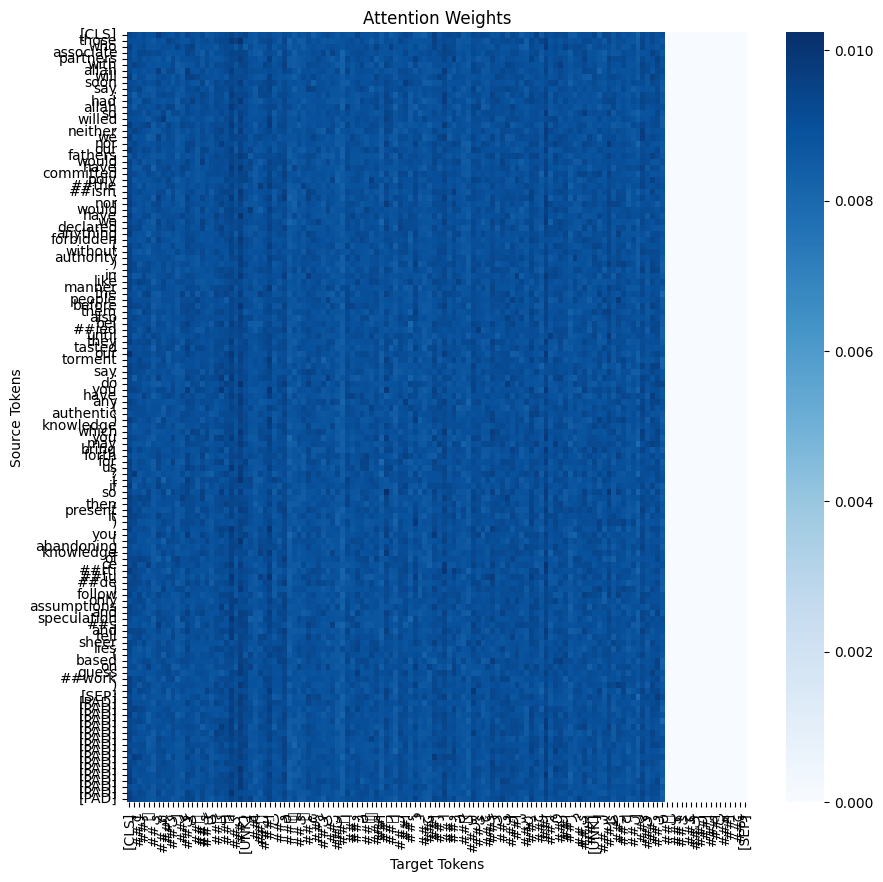

In [32]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot attention weights
def plot_attention_weights(attention_weights, src_batch, tgt_batch, tokenizer):
    # Inspect the content of the attention_weights tuple
    print(f"Type of attention_weights: {type(attention_weights)}")
    print(f"Contents of attention_weights tuple: {attention_weights}")
    
    # Assuming the actual attention weights are in the first element of the tuple
    attention = attention_weights[0]  # Extract attention weights from the tuple
    
    # Inspect the shape of the attention weights to ensure correct format
    print(f"Attention weights shape: {attention.shape}")
    
    # Get attention weights from the first layer (assuming 0th index is the first layer)
    attention = attention[0]  # Attention weights from the first layer (shape: [num_heads, seq_len, seq_len])
    
    # Average over all attention heads (shape: [seq_len, seq_len])
    attention = attention.mean(dim=0)  # Averaging across heads (shape: [seq_len, seq_len])
    
    # Squeeze to remove the batch dimension and convert to numpy
    attention = attention.squeeze(0).cpu().numpy()  # Shape should be [seq_len, seq_len] now

    # Convert source and target token ids to actual tokens
    src_tokens = tokenizer.convert_ids_to_tokens(src_batch.tolist())
    tgt_tokens = tokenizer.convert_ids_to_tokens(tgt_batch.tolist())
    
    # Ensure the lengths of tokens match the attention matrix
    src_tokens = src_tokens[:len(attention)]  # Ensure the source tokens are the same length as the attention matrix
    tgt_tokens = tgt_tokens[:len(attention)]  # Same for target tokens

    # Plot the heatmap of attention weights
    plt.figure(figsize=(10, 10))
    sns.heatmap(attention, xticklabels=tgt_tokens, yticklabels=src_tokens, cmap="Blues")
    plt.title("Attention Weights")
    plt.xlabel("Target Tokens")
    plt.ylabel("Source Tokens")
    plt.show()

# Sample batch shapes for inspection
for src_batch, tgt_batch in train_loader:
    # Get attention weights for a sample batch
    attention_weights = get_attention_weights(model, src_batch, tgt_batch, torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    
    # Check the type and content of attention weights
    print(f"Attention weights: {attention_weights}")
    
    # Visualize the attention for the first example in the batch
    plot_attention_weights(attention_weights, src_batch[0], tgt_batch[0], tokenizer)
    break  # Break after processing the first batch
